Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Teacher Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\vit\modeling_vit.py:277: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
Teacher Epoch 1/10: 100%|██████████| 391/391 [50:31<00:00,  7.75s/it]


Epoch 1, Loss: 215.9130, Accuracy: 0.8373


Teacher Epoch 2/10: 100%|██████████| 391/391 [46:01<00:00,  7.06s/it]


Epoch 2, Loss: 155.9657, Accuracy: 0.9345


Teacher Epoch 3/10: 100%|██████████| 391/391 [45:20<00:00,  6.96s/it]


Epoch 3, Loss: 148.8656, Accuracy: 0.9430


Teacher Epoch 4/10: 100%|██████████| 391/391 [42:56<00:00,  6.59s/it]


Epoch 4, Loss: 139.9028, Accuracy: 0.9592


Teacher Epoch 5/10: 100%|██████████| 391/391 [43:02<00:00,  6.61s/it]


Epoch 5, Loss: 136.6228, Accuracy: 0.9627


Teacher Epoch 6/10: 100%|██████████| 391/391 [43:13<00:00,  6.63s/it]


Epoch 6, Loss: 136.5650, Accuracy: 0.9640


Teacher Epoch 7/10: 100%|██████████| 391/391 [43:13<00:00,  6.63s/it]


Epoch 7, Loss: 134.3238, Accuracy: 0.9673


Teacher Epoch 8/10: 100%|██████████| 391/391 [43:00<00:00,  6.60s/it]


Epoch 8, Loss: 133.3051, Accuracy: 0.9701


Teacher Epoch 9/10: 100%|██████████| 391/391 [43:11<00:00,  6.63s/it]


Epoch 9, Loss: 129.6033, Accuracy: 0.9728


Teacher Epoch 10/10: 100%|██████████| 391/391 [43:05<00:00,  6.61s/it]


Epoch 10, Loss: 131.8982, Accuracy: 0.9729

Classification Report:
              precision    recall  f1-score   support

     IR Real       0.97      0.96      0.96      1148
     OR Real       0.95      0.96      0.96       954
      Normal       1.00      1.00      1.00       575

    accuracy                           0.97      2677
   macro avg       0.97      0.97      0.97      2677
weighted avg       0.97      0.97      0.97      2677



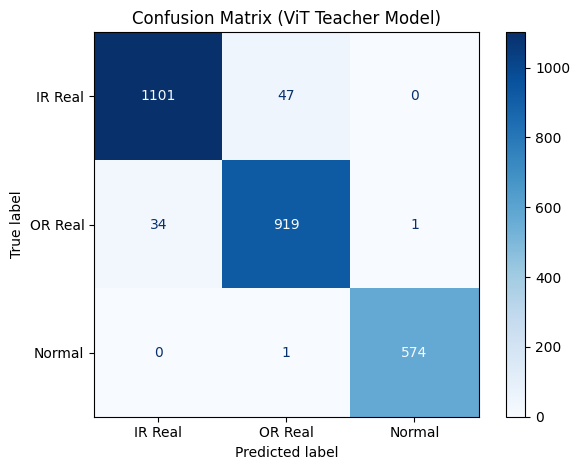

In [1]:
# Updated ViT-Based Semi-Supervised Fault Diagnosis with 99%+ Accuracy Goal

import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn, optim
from transformers import ViTForImageClassification

# 1. Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = r"E:\Collaboration Work\With Farooq\Bearings MDPI\Real paderborn"
class_map = {"IR Real": 0, "OR Real": 1, "Normal": 2}

# 2. Transformations (strong augmentation)
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# 3. Dataset definition
class ScalogramDataset(Dataset):
    def __init__(self, image_paths, labels=None, transform=None, labeled=True):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.labeled = labeled

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        if self.labeled:
            return image, torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return image

# 4. Load all data (100% as labeled to train a better teacher)
all_image_paths, all_labels = [], []
for class_name, label in class_map.items():
    folder = os.path.join(data_dir, class_name)
    for file in glob.glob(os.path.join(folder, '*.png')):
        all_image_paths.append(file)
        all_labels.append(label)

train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.3, stratify=all_labels, random_state=42)

train_dataset = ScalogramDataset(train_paths, train_labels, transform=transform, labeled=True)
test_dataset = ScalogramDataset(test_paths, test_labels, transform=transform, labeled=True)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 5. Model, optimizer, and loss
teacher_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k", num_labels=len(class_map)).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(teacher_model.parameters(), lr=3e-5)

# 6. Teacher training (100% labeled)
def train_model(model, loader, criterion, optimizer, device, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for images, labels in tqdm(loader, desc=f"Teacher Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(images).logits
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (logits.argmax(1) == labels).sum().item()
            total += labels.size(0)
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {correct/total:.4f}")

train_model(teacher_model, train_loader, criterion, optimizer, device, epochs=10)

# 7. Evaluation
teacher_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = teacher_model(images).logits
        preds = logits.argmax(1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(class_map.keys())))
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=list(class_map.keys())).plot(cmap="Blues")
plt.title("Confusion Matrix (ViT Teacher Model)")
plt.tight_layout()
plt.show()


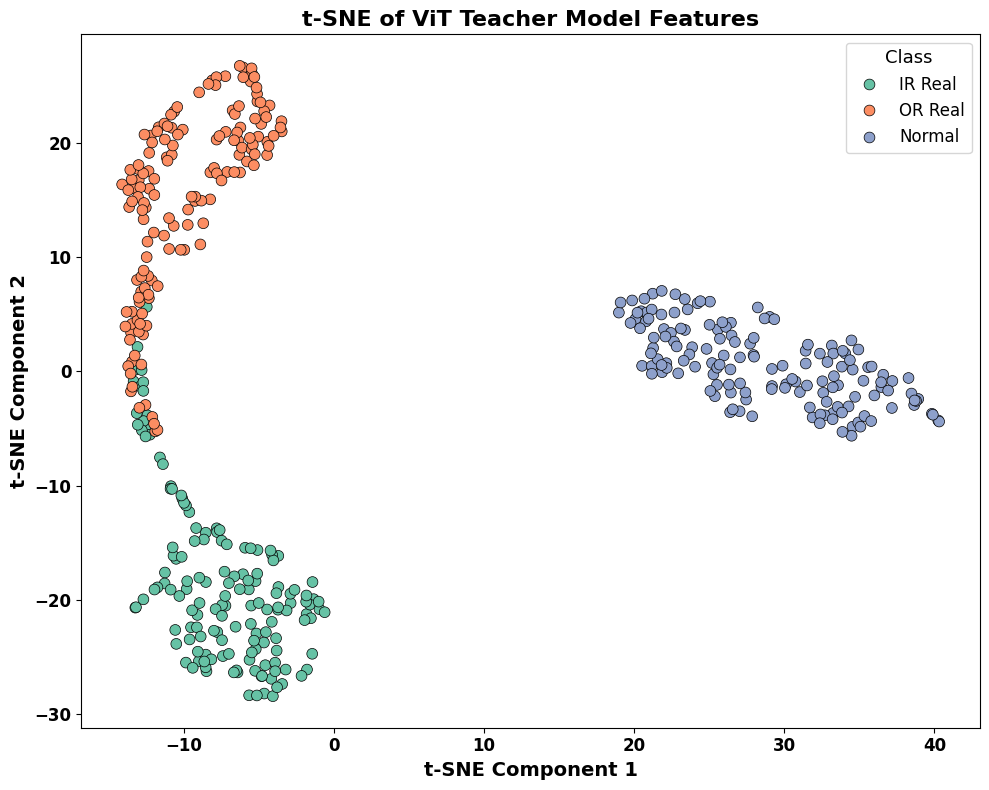

In [3]:
from sklearn.manifold import TSNE
import seaborn as sns

# 1. Extract features (logits) and labels from the model
def extract_features(model, dataloader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            outputs = model(images).logits  # raw logits
            features.extend(outputs.cpu().numpy())
            labels.extend(lbls.numpy())
    return np.array(features), np.array(labels)

# 2. Apply t-SNE
features, labels = extract_features(teacher_model, test_loader, device)

# Optional: Subsample for memory efficiency (e.g., 150 per class)
np.random.seed(42)
subset_indices = []
for class_id in np.unique(labels):
    idxs = np.where(labels == class_id)[0]
    chosen = np.random.choice(idxs, size=min(150, len(idxs)), replace=False)
    subset_indices.extend(chosen)

features_sub = features[subset_indices]
labels_sub = labels[subset_indices]

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features_sub)

# 3. Plot with Seaborn (pretty styling)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    hue=[list(class_map.keys())[i] for i in labels_sub],
    palette='Set2',
    s=60,
    edgecolor='black',
    linewidth=0.5
)
plt.title("t-SNE of ViT Teacher Model Features", fontsize=16, fontweight='bold')
plt.xlabel("t-SNE Component 1", fontsize=14, fontweight='bold')
plt.ylabel("t-SNE Component 2", fontsize=14, fontweight='bold')
plt.legend(title="Class", fontsize=12, title_fontsize=13)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()
#plt.savefig("vit_tsne_features.png", dpi=600)
plt.show()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/25: 100%|██████████| 391/391 [48:47<00:00,  7.49s/it]


Epoch 1, Loss: 254.6294, Accuracy: 0.8019


Epoch 2/25: 100%|██████████| 391/391 [49:23<00:00,  7.58s/it]


Epoch 2, Loss: 170.4336, Accuracy: 0.9119


Epoch 3/25: 100%|██████████| 391/391 [1:01:52<00:00,  9.50s/it]


Epoch 3, Loss: 154.1040, Accuracy: 0.9366


Epoch 4/25: 100%|██████████| 391/391 [53:40<00:00,  8.24s/it] 


Epoch 4, Loss: 147.6024, Accuracy: 0.9460


Epoch 5/25: 100%|██████████| 391/391 [48:43<00:00,  7.48s/it]


Epoch 5, Loss: 144.8847, Accuracy: 0.9504


Epoch 6/25: 100%|██████████| 391/391 [49:05<00:00,  7.53s/it]


Epoch 6, Loss: 139.8587, Accuracy: 0.9582


Epoch 7/25: 100%|██████████| 391/391 [49:37<00:00,  7.62s/it]


Epoch 7, Loss: 140.3103, Accuracy: 0.9582


Epoch 8/25: 100%|██████████| 391/391 [53:01<00:00,  8.14s/it]


Epoch 8, Loss: 135.5577, Accuracy: 0.9654


Epoch 9/25: 100%|██████████| 391/391 [56:36<00:00,  8.69s/it]


Epoch 9, Loss: 133.5255, Accuracy: 0.9691


Epoch 10/25: 100%|██████████| 391/391 [56:46<00:00,  8.71s/it]


Epoch 10, Loss: 132.1768, Accuracy: 0.9699


Epoch 11/25: 100%|██████████| 391/391 [56:44<00:00,  8.71s/it]


Epoch 11, Loss: 131.4411, Accuracy: 0.9737


Epoch 12/25: 100%|██████████| 391/391 [58:14<00:00,  8.94s/it]


Epoch 12, Loss: 130.6516, Accuracy: 0.9736


Epoch 13/25: 100%|██████████| 391/391 [56:42<00:00,  8.70s/it]


Epoch 13, Loss: 129.5616, Accuracy: 0.9747


Epoch 14/25: 100%|██████████| 391/391 [58:57<00:00,  9.05s/it] 


Epoch 14, Loss: 127.6990, Accuracy: 0.9785


Epoch 15/25: 100%|██████████| 391/391 [56:54<00:00,  8.73s/it]


Epoch 15, Loss: 125.6856, Accuracy: 0.9827


Epoch 16/25: 100%|██████████| 391/391 [56:58<00:00,  8.74s/it] 


Epoch 16, Loss: 126.7191, Accuracy: 0.9809


Epoch 17/25: 100%|██████████| 391/391 [55:25<00:00,  8.50s/it]


Epoch 17, Loss: 124.9752, Accuracy: 0.9832


Epoch 18/25: 100%|██████████| 391/391 [55:31<00:00,  8.52s/it]


Epoch 18, Loss: 124.4699, Accuracy: 0.9829


Epoch 19/25: 100%|██████████| 391/391 [55:24<00:00,  8.50s/it]


Epoch 19, Loss: 122.6959, Accuracy: 0.9869


Epoch 20/25: 100%|██████████| 391/391 [55:29<00:00,  8.52s/it]


Epoch 20, Loss: 122.4707, Accuracy: 0.9877


Epoch 21/25: 100%|██████████| 391/391 [55:24<00:00,  8.50s/it]


Epoch 21, Loss: 122.8175, Accuracy: 0.9867


Epoch 22/25: 100%|██████████| 391/391 [55:26<00:00,  8.51s/it]


Epoch 22, Loss: 121.5649, Accuracy: 0.9885


Epoch 23/25: 100%|██████████| 391/391 [55:30<00:00,  8.52s/it]


Epoch 23, Loss: 120.1523, Accuracy: 0.9923


Epoch 24/25: 100%|██████████| 391/391 [55:46<00:00,  8.56s/it]


Epoch 24, Loss: 120.9769, Accuracy: 0.9893


Epoch 25/25: 100%|██████████| 391/391 [55:37<00:00,  8.54s/it]


Epoch 25, Loss: 120.9150, Accuracy: 0.9902

Classification Report:
              precision    recall  f1-score   support

     IR Real       0.99      0.98      0.99      1148
     OR Real       0.98      0.99      0.98       954
      Normal       1.00      1.00      1.00       575

    accuracy                           0.99      2677
   macro avg       0.99      0.99      0.99      2677
weighted avg       0.99      0.99      0.99      2677



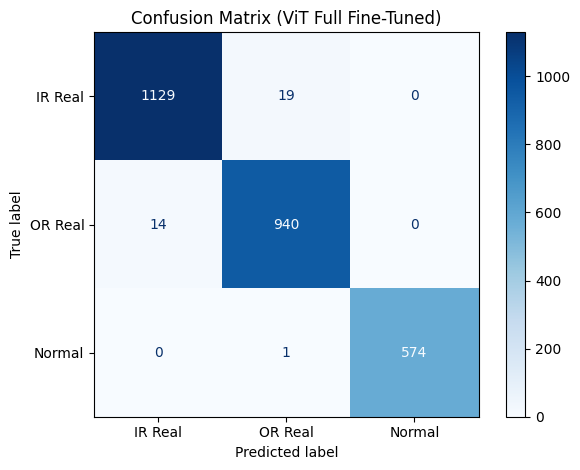

In [4]:
# ViT-Based Paderborn Dataset Classification with Target of 100% Accuracy

import os
import glob
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn, optim
from transformers import ViTForImageClassification

# 1. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = r"E:\Collaboration Work\With Farooq\Bearings MDPI\Real paderborn"
class_map = {"IR Real": 0, "OR Real": 1, "Normal": 2}

# 2. Stronger Augmentations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomApply([transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)], p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# 3. Dataset Class
class ScalogramDataset(Dataset):
    def __init__(self, image_paths, labels=None, transform=None, labeled=True):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.labeled = labeled

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        if self.labeled:
            return image, torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return image

# 4. Load Data
all_image_paths, all_labels = [], []
for class_name, label in class_map.items():
    folder = os.path.join(data_dir, class_name)
    for file in glob.glob(os.path.join(folder, '*.png')):
        all_image_paths.append(file)
        all_labels.append(label)

train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.3, stratify=all_labels, random_state=42)

train_dataset = ScalogramDataset(train_paths, train_labels, transform=transform, labeled=True)
test_dataset = ScalogramDataset(test_paths, test_labels, transform=transform, labeled=True)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 5. Model Setup
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k", num_labels=len(class_map)).to(device)

# Unfreeze All Layers
for param in model.parameters():
    param.requires_grad = True

# Loss and Optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)

# 6. Training Function
def train_model(model, loader, criterion, optimizer, scheduler, device, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for images, labels in tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(images).logits
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (logits.argmax(1) == labels).sum().item()
            total += labels.size(0)
        scheduler.step()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {correct/total:.4f}")

# 7. Start Training
train_model(model, train_loader, criterion, optimizer, scheduler, device, epochs=25)

# 8. Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images).logits
        preds = logits.argmax(1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

# 9. Metrics and Confusion Matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(class_map.keys())))
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=list(class_map.keys())).plot(cmap="Blues")
plt.title("Confusion Matrix (ViT Full Fine-Tuned)")
plt.tight_layout()
plt.show()


Extracting features: 100%|██████████| 168/168 [04:55<00:00,  1.76s/it]
c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


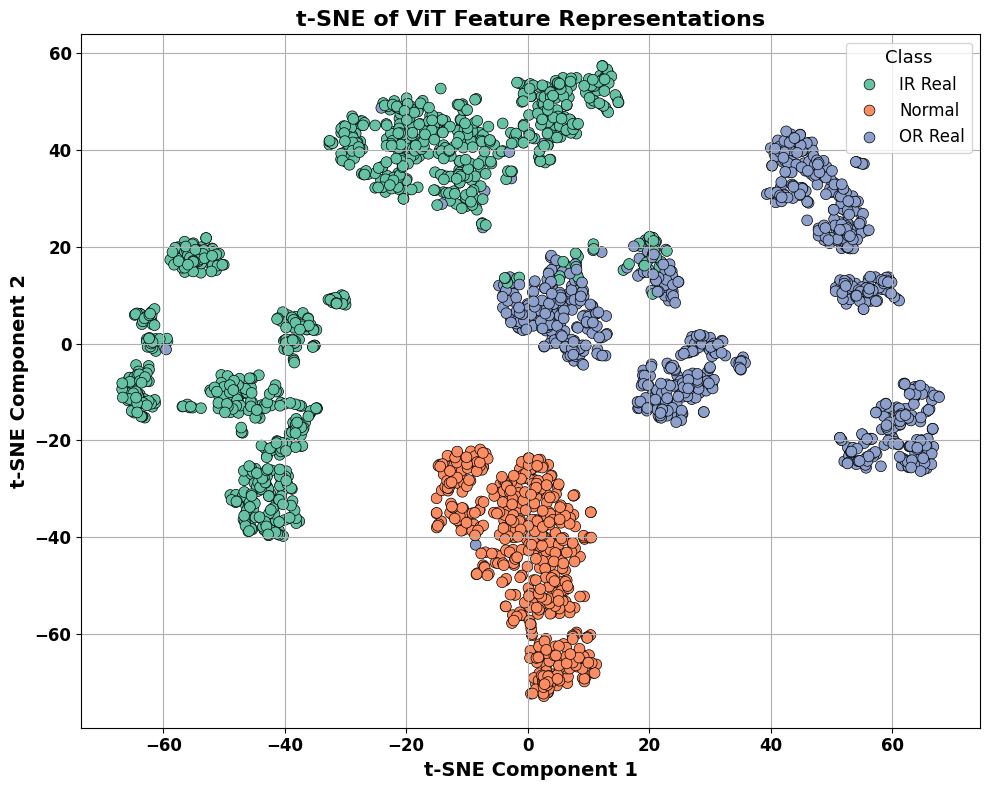

In [12]:
import seaborn as sns
from sklearn.manifold import TSNE

# Step 1: Extract features from ViT (CLS token)
def extract_features(model, loader, device):
    model.eval()
    features, labels_list = [], []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Extracting features"):
            images = images.to(device)
            outputs = model.vit(images).last_hidden_state[:, 0, :]  # CLS token
            features.append(outputs.cpu().numpy())
            labels_list.extend(labels.numpy())

    return np.vstack(features), np.array(labels_list)

# Step 2: Apply t-SNE
tsne_features, class_idx = extract_features(model, test_loader, device)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(tsne_features)

# Step 3: Plot with Seaborn (Pretty Style)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    hue=[list(class_map.keys())[i] for i in class_idx],
    palette='Set2',
    s=60,
    edgecolor='black',
    linewidth=0.5
)
plt.title("t-SNE of ViT Feature Representations", fontsize=16, fontweight='bold')
plt.xlabel("t-SNE Component 1", fontsize=14, fontweight='bold')
plt.ylabel("t-SNE Component 2", fontsize=14, fontweight='bold')
plt.legend(title="Class", fontsize=12, title_fontsize=13)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.grid(True)
plt.tight_layout()
# plt.savefig("vit_tsne_features.png", dpi=600)
plt.show()


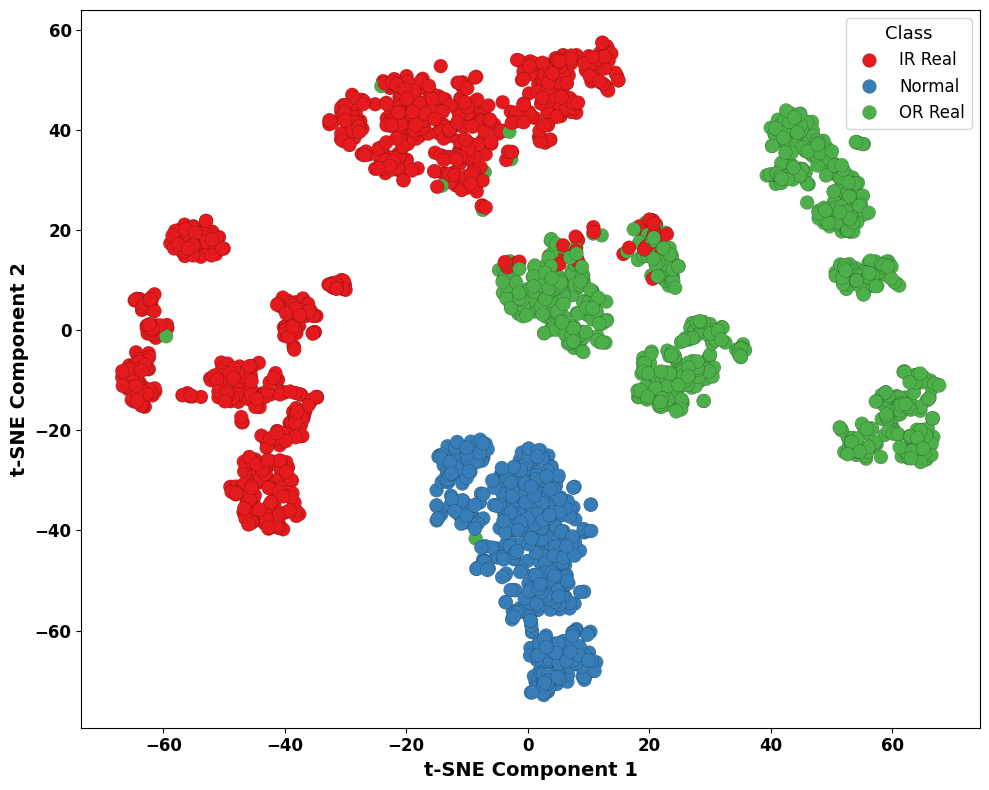

In [17]:
# Step 3: Plot with Seaborn (Pretty Style)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    hue=[list(class_map.keys())[i] for i in class_idx],
    palette='Set1',
    s=100,
    edgecolor='black',
    linewidth=0.1
)
#plt.title("t-SNE of ViT Feature Representations", fontsize=16, fontweight='bold')
plt.xlabel("t-SNE Component 1", fontsize=14, fontweight='bold')
plt.ylabel("t-SNE Component 2", fontsize=14, fontweight='bold')
plt.legend(title="Class", fontsize=12, title_fontsize=13)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
#plt.grid(True)
plt.tight_layout()
# plt.savefig("vit_tsne_features.png", dpi=600)
plt.show()

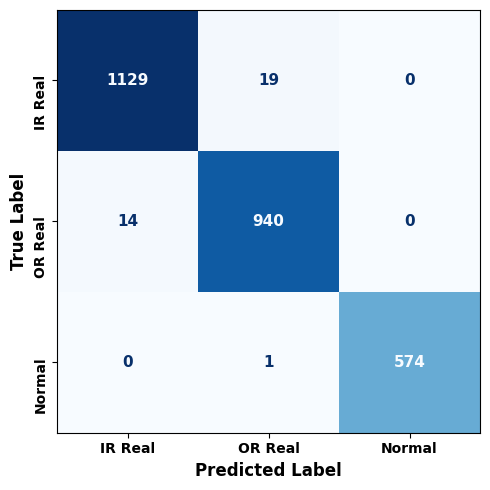

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_map.keys()))

# Step 2: Custom Styled Plot
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax, colorbar=False)

# Step 3: Customize Text
for row in disp.text_:
    for text in row:
        text.set_fontweight('bold')
        text.set_fontsize(11)

# Step 4: Customize Axes
ax.set_xlabel("Predicted Label", fontsize=12, fontweight='bold')
ax.set_ylabel("True Label", fontsize=12, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold', rotation=0)
plt.yticks(fontsize=10, fontweight='bold', rotation=90)
plt.tight_layout()

# Step 5: Save (optional)
# plt.savefig("results/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()


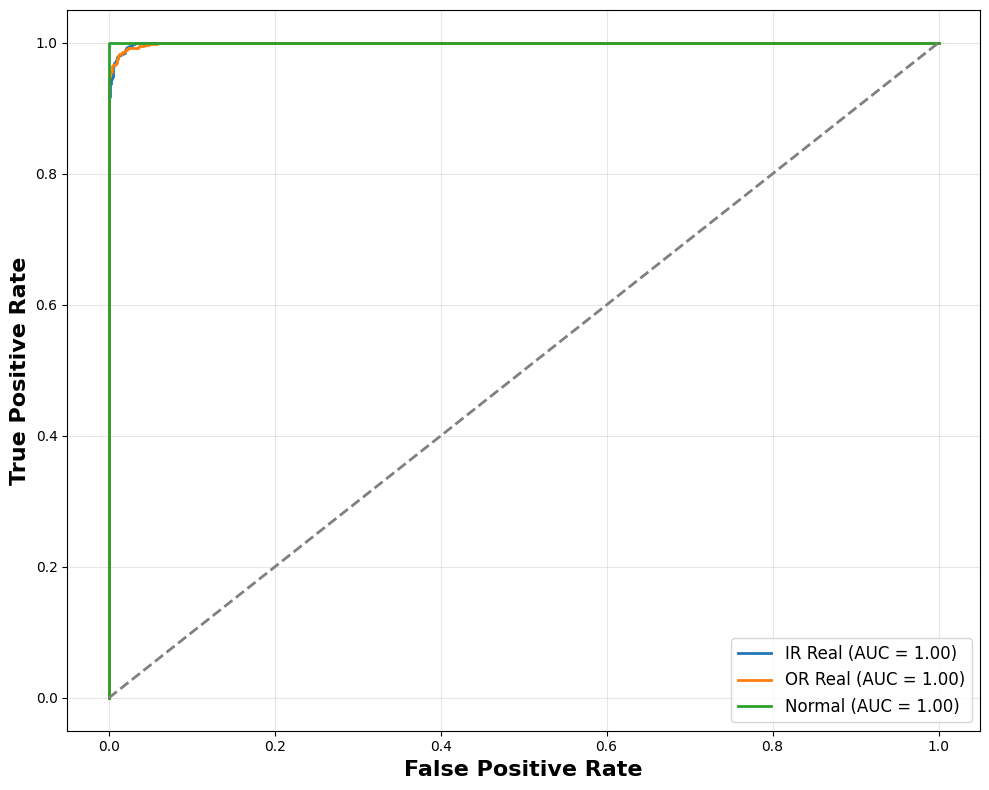

In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Step 1: Binarize the labels (needed for multi-class ROC)
y_true_bin = label_binarize(y_true, classes=list(range(len(class_map))))
num_classes = y_true_bin.shape[1]

# Step 2: Get model predicted probabilities
model.eval()
y_scores = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        logits = model(images).logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        y_scores.extend(probs)

y_scores = np.array(y_scores)

# Step 3: Compute FPR, TPR, AUC for each class
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Plot the ROC Curve
plt.figure(figsize=(10, 8))
classes = list(class_map.keys())

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
# plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
# plt.savefig("vit_roc_curve.png", dpi=1000)
plt.show()


In [20]:
from sklearn.metrics import classification_report

# Ensure y_true and y_pred are available from earlier evaluation step
# If not, repeat the prediction step:
# model.eval()
# y_true, y_pred = [], []
# with torch.no_grad():
#     for images, labels in test_loader:
#         images = images.to(device)
#         logits = model(images).logits
#         preds = logits.argmax(1).cpu().numpy()
#         y_true.extend(labels.numpy())
#         y_pred.extend(preds)

# Print classification report
print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(class_map.keys()),
    digits=4
))



Classification Report:
              precision    recall  f1-score   support

     IR Real     0.9878    0.9834    0.9856      1148
     OR Real     0.9792    0.9853    0.9822       954
      Normal     1.0000    0.9983    0.9991       575

    accuracy                         0.9873      2677
   macro avg     0.9890    0.9890    0.9890      2677
weighted avg     0.9873    0.9873    0.9873      2677



In [21]:
from sklearn.metrics import confusion_matrix

# Ensure y_true and y_pred are already computed
cm = confusion_matrix(y_true, y_pred)

print("\nClass-wise TPR, FPR, FNR, and FDR:")
print(f"{'Class':<18} {'TPR':>10} {'FPR':>10} {'FNR':>10} {'FDR':>10}")
print("-" * 60)

for i, class_name in enumerate(class_map.keys()):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity / Recall
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    FNR = FN / (TP + FN) if (TP + FN) > 0 else 0
    FDR = FP / (TP + FP) if (TP + FP) > 0 else 0

    print(f"{class_name:<18} {TPR:>10.4f} {FPR:>10.4f} {FNR:>10.4f} {FDR:>10.4f}")



Class-wise TPR, FPR, FNR, and FDR:
Class                     TPR        FPR        FNR        FDR
------------------------------------------------------------
IR Real                0.9834     0.0092     0.0166     0.0122
OR Real                0.9853     0.0116     0.0147     0.0208
Normal                 0.9983     0.0000     0.0017     0.0000
